In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Compute Gallery,394.389775,9.859744,16.059811,40
Open Source/GitHub,642.404479,107.067413,179.625601,6
C# Basics,651.785916,21.025352,30.431810,31
Azure Private DNS,759.111864,39.953256,63.520360,19
RAG Project,879.236429,54.952277,123.403473,16
Azure AD Authentication,961.912471,73.993267,178.639817,13
Azure Functions + Visual Studio,1048.491494,80.653192,287.883246,13
Audit Report Tracker (Sharepoint List),1076.845432,97.895039,272.339386,11
Email Auth and Security,1083.294551,90.274546,186.637068,12
WSL + Kali Linux,1373.907506,98.136250,388.847878,14


# Histogram

sum of ages: ~48576.95


<Axes: >

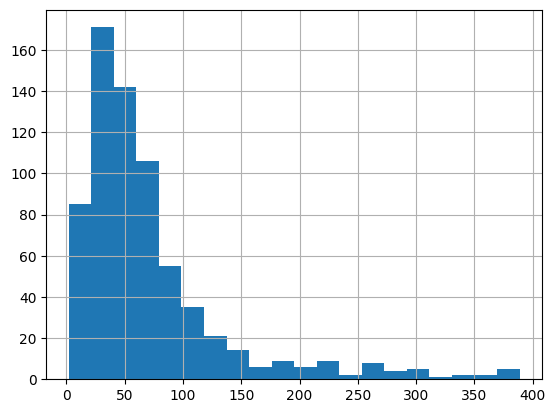

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 688
Total card age: 48576.95


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
8,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-388.847878,98.136250,-388.847878,1373.907506,0.380510,0,0
9,WSL + Kali Linux,XFCE (XForms Common Environment)\nA lightweigh...,c8efa98ee24e569ac00bd9c851ed275d,-76.287259,98.136250,-388.847878,1373.907506,0.380510,3,0
10,WSL + Kali Linux,12. wsl --mount\nA feature introduced with WSL...,e2b2421dc6e68e8799e0313e062ef742,-60.854666,98.136250,-388.847878,1373.907506,0.380510,6,0
11,WSL + Kali Linux,"/mnt Directory\nIn WSL, the /mnt directory is ...",1754be0fa722a91c516a9269bf2b138d,-50.017338,98.136250,-388.847878,1373.907506,0.380510,9,0
12,WSL + Kali Linux,WSL File System Performance\nThe file system i...,b0312406e43d296e4ab374a81ae068ec,-31.821859,98.136250,-388.847878,1373.907506,0.380510,12,0
13,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-387.421284,75.629987,-387.421284,4764.689152,0.263927,0,0
14,PnP PowerShell,Admin Consent\nApproval granted by an Azure AD...,c43e453a3677efe89b3c4fd5a55a5187,-215.847421,75.629987,-387.421284,4764.689152,0.263927,3,0
15,PnP PowerShell,Get-PnPWeb (PnP.PowerShell)\nFetches details a...,39de603241316a1e5cb54a9f4444b467,-136.530016,75.629987,-387.421284,4764.689152,0.263927,6,0
16,PnP PowerShell,Client Secret (client_secret)\nA confidential ...,b5c0ee9ec7b019a15e59ad68a9fe8848,-104.602003,75.629987,-387.421284,4764.689152,0.263927,9,0
484,PnP PowerShell,Delegated Permissions\nPermissions granted to ...,53d0d302c9f3f7d4b92f4b022a587641,-93.466898,75.629987,-387.421284,4764.689152,0.263927,12,0


## Card Count

In [15]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
8,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-388.847878,98.136250,-388.847878,1373.907506,0.380510,0,0
13,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-387.421284,75.629987,-387.421284,4764.689152,0.263927,0,0
233,PowerShell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-383.400566,95.501630,-383.400566,3533.560320,0.857961,0,0
60,Azure Developer Associate,Which Azure Monitor table holds platform metri...,52fbf976aa2ccee89121f7b5694acfce,-370.045079,74.638680,-370.045079,4105.127404,0.137283,0,0
34,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-369.873624,93.559900,-369.873624,4865.114789,0.966325,0,0
463,PowerShell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,-356.825808,95.501630,-383.400566,3533.560320,0.857961,1,1
52,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-352.727750,77.441776,-352.727750,1858.602631,0.821518,0,0
79,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,-342.632315,72.873266,-342.632315,2477.691029,0.062970,0,0
317,FSLogix,Q: Which format does FSLogix use to store user...,2502a81cff9047e83fa1e04a99225de5,-337.025830,72.873266,-342.632315,2477.691029,0.062970,1,1
91,Vocab,"Red Side Story, FForde\nParboil\nPronunciation...",1ee9362f92872e44aac4c6b02749add8,-312.860624,59.245082,-312.860624,4798.851621,0.124412,0,0


In [18]:
existing_cards.head(10).sum()

head                   WSL + Kali LinuxWSL + Kali LinuxWSL + Kali Lin...
body                   WSLg (Windows Subsystem for Linux GUI)\nA feat...
hash                   69051af876862485bdb54d8c645a8a40c8efa98ee24e56...
age                                                         -1545.696624
subject_mean_age                                              868.831185
subject_highest_age                                          -3881.34581
subject_age_sum                                              30692.98329
head_random_roll                                                3.222181
count                                                                 60
n_fold                                                                 0
dtype: object

In [19]:
existing_cards['age'].mean()

-70.60602819094717